Tests des scores de classifications internes sur des données-jouets
===============

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs,make_moons
from sklearn.metrics import silhouette_score,calinski_harabaz_score,davies_bouldin_score
%matplotlib inline

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [10, 10]
mpl.rcParams['font.size'] = 15

Création des jeux de données
-----------------------------
Ces jeux de données "jouet", générés automatiquement par Python, permettent de contrôler tous les paramètres dont on veut tester l'influence : nombre de points, séparabilité des clusters, densité...
Pour s'assurer de la lisibilité des données, nous nous limitons à un espace des features en 2 dimensions.

Trois jeux de données sont utilisés :
  * "Good blobs" : trois clusters générés selon des gaussiennes bien séparées
  * "Bad blobs" : trois cluster générés selon des gaussiennes, mais deux des gaussiennes se chevauchent.
  * "Moons" : deux clusters en demi-lune, bien séparés à l'oeil nu, mais très difficile à séparer par des algorithmes de clustering (pas de frontière linéaire)
  * "Uniform" : deux clusters choisis aléatoirement dans un nuage de points (selon une loi uniforme), impossibles à distinguer

In [3]:
N=1000
goodclassif_seed=418
badclassif_seed=4

### Good blobs
Trois clusters générés selon des gaussiennes bien séparées

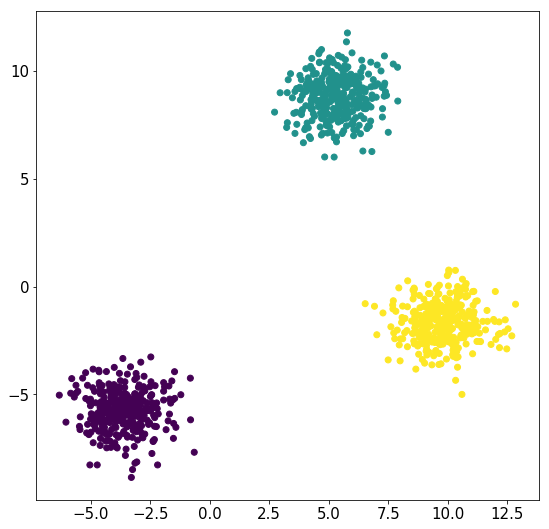

In [4]:
X_gblobs, y_gblobs = make_blobs(n_samples=N,random_state=goodclassif_seed)

plt.figure(figsize=(9,9))
plt.scatter(X_gblobs[:, 0], X_gblobs[:, 1], c=y_gblobs)

### Bad blobs
Trois cluster générés selon des gaussiennes, mais deux des gaussiennes se chevauchent.

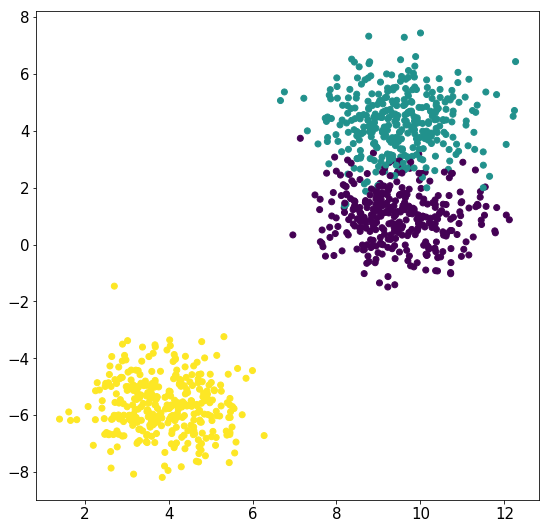

In [5]:
X_bblobs, y_bblobs = make_blobs(n_samples=N,random_state=badclassif_seed)

plt.figure(figsize=(9,9))
plt.scatter(X_bblobs[:, 0], X_bblobs[:, 1], c=y_bblobs)

### Moons
Deux clusters en demi-lune, bien séparés à l'oeil nu, mais très difficile à séparer par des algorithmes de clustering (pas de frontière linéaire)

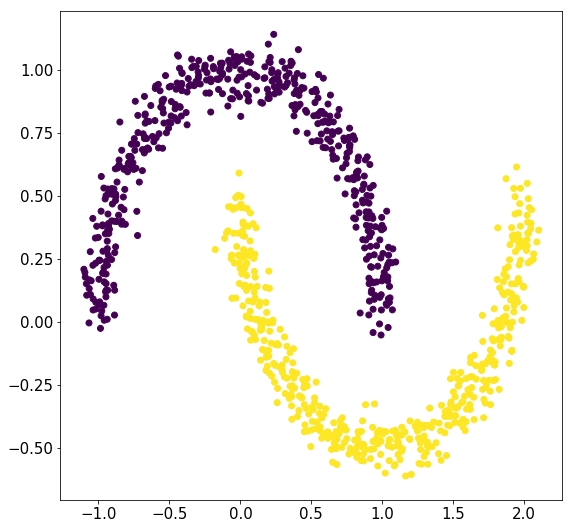

In [6]:
X_moons, y_moons = make_moons(n_samples=N,noise=0.06)
plt.figure(figsize=(9,9))
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons)

### Uniform
Deux clusters choisis aléatoirement dans un nuage de points (selon une loi uniforme), impossibles à distinguer

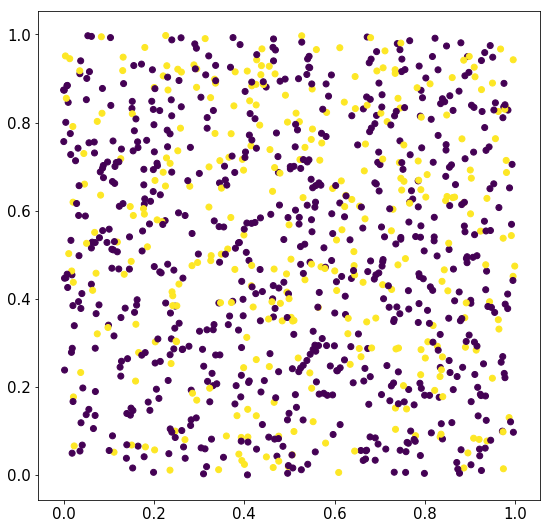

In [7]:
X_unif = np.random.rand(N,N)
X_unif.shape
y_unif = np.zeros(N,dtype=int)
y_unif[np.random.choice(np.arange(N),size=int(N/2.5))]=1
plt.figure(figsize=(9,9))
plt.scatter(X_unif[:, 0], X_unif[:, 1], c=y_unif)

In [8]:
datasets = [X_gblobs,X_bblobs,X_moons,X_unif]
truelabels = [y_gblobs,y_bblobs,y_moons,y_unif]
datasetnames = ["Good blobs","Bad blobs","Moons",'Uniform']

Calcul des scores
-----------------
Trois scores sont testés dans cette expérience :
  * Silhouette
  * Calinski-Harabasz
  * Davies-Bouldin

Chacun des scores est calculé sur les jeux de données **supervisés** (aucun algo de clustering n'a tourné pour l'instant).
Ces scores devraient refléter la *séparabilité* des clusters.

### Score de silhouette
Le score de silhouette est calculé pour chaque point du jeu de données : il vaut 1 si le point est parfaitement classé, -1 s'il est extrèmement mal classé. Pour le jeu de donnée entier, on fait la moyenne sur tous les points d'un cluster, puis sur tous les clusters.

In [9]:
for X,y,name in zip(datasets,truelabels,datasetnames):
    s_score=silhouette_score(X,y)
    print("Silhouette score of dataset",name,"=",s_score)

Silhouette score of dataset Good blobs = 0.857032344145763
Silhouette score of dataset Bad blobs = 0.5901517094435283
Silhouette score of dataset Moons = 0.333215579714209
Silhouette score of dataset Uniform = 0.0003391215309989072


### Score de Calinski-Harabasz
Le score de Calinski-Harabasz est calculé sur tout le jeu de donnée : c'est le rapport entre la variance intra-cluster et la variance inter-cluster. Il faut 0 pour la pire classification et +l'infini pour la meilleure.

In [10]:
for X,y,name in zip(datasets,truelabels,datasetnames):
    ch_score=calinski_harabaz_score(X,y)
    print("Calinski-Harabasz score of dataset",name,"=",ch_score)

Calinski-Harabasz score of dataset Good blobs = 17945.953070073218
Calinski-Harabasz score of dataset Bad blobs = 6355.697570051757
Calinski-Harabasz score of dataset Moons = 660.8954008599013
Calinski-Harabasz score of dataset Uniform = 0.970368307457868


### Score de Davies-Bouldin
Le score de Davies-Bouldin est calculé sur tout le jeu de donnée : il compare la distance entre les points et le centre de leur cluster aux distances entre les centres de cluster. Il vaut 0 pour la meilleure des classifications, +l'infini pour la pire.

In [11]:
for X,y,name in zip(datasets,truelabels,datasetnames):
    # Bypass a RuntimeWarning of the function
    with np.errstate(divide='ignore'):
        db_score=davies_bouldin_score(X,y)
    print("Davies-Bouldin score of dataset",name,"=",db_score)

Davies-Bouldin score of dataset Good blobs = 0.20287359839398003
Davies-Bouldin score of dataset Bad blobs = 0.5900906043550904
Davies-Bouldin score of dataset Moons = 1.1544584043814596
Davies-Bouldin score of dataset Uniform = 29.972625863554356


### Conclusion
On voit que les 3 scores donnent le même classement :
  1. Good blobs
  2. Bad blobs
  3. Moons
  4. Uniform (loin derrière...)

Il est rassurant de voir que "Good blobs" arrive en tête et que "Uniform" soit dernier. En revanche il est surprenant que "Bab blobs", dans lequel deux clusters se chevauchent, soit mieux classé que "Moons", nettement séparés mais de forme complexe.

On retiendra donc de cette expérience que la forme des clusters peut avoir un impact sur les scores : les trois scores testés ne sont pas adaptés pour rendre compte de la séparabilité des clusters allongés tels que "Moons".

Stabilité des scores
====================
On veut tester l'influence des scores lorsque varient plusieurs paramètres :
  * Le nombre de points
  * L'étendue du domaine de variation

Pour cela, on commence par une fonction.

In [86]:
def generate_dataset(datasetname,N=1000,dilatation=1):
    '''Generate dataset according to the given parameters.'''
    
    if datasetname=='gblobs':
        X, y = make_blobs(n_samples=N,random_state=418)
    elif datasetname=='bblobs':
        X, y = make_blobs(n_samples=N,random_state=418)
    elif datasetname=='moons':
        X, y = make_moons(n_samples=N,noise=0.06)
    elif datasetname=='unif':
        X = np.random.rand(N,N)
        y = np.zeros(N,dtype=int)
        y[np.random.choice(np.arange(N),size=int(N/2.5))]=1
    else:
        raise ValueError("Unknown dataset name. Must be one of ['gblobs','bblobs','moons']")
    
    X=dilatation*X
    
    return X,y

In [87]:
N_values= [200,500,1000,2000,5000,10000]
dil_values=[0.01,0.1,1,5,10,50]
data_names=['gblobs','bblobs','moons','unif']

In [88]:
df=pd.DataFrame(columns=['datasetname','N','dilatation','s_score','ch_score','db_score','s_chrono','ch_chrono','db_chrono'])
XN,XD,Xdn = np.meshgrid(N_values,dil_values,data_names)
for N,dil,dname in zip(XN.ravel(),XD.ravel(),Xdn.ravel()):
    X, y = generate_dataset(dname,N,dil)
    
    t0=time.time()
    s_score=silhouette_score(X,y)
    t1=time.time()    
    ch_score=calinski_harabaz_score(X,y)
    t2=time.time()
    with np.errstate(divide='ignore'):
        db_score=davies_bouldin_score(X,y)
    t3=time.time()
    
    df.loc[len(df)]=[dname,N,dil,s_score,ch_score,db_score,t1-t0,t2-t1,t3-t2]
    

In [144]:
df.head(20)

,datasetname,N,dilatation,s_score,ch_score,db_score,s_chrono,ch_chrono,db_chrono
0,gblobs,200,0.01,0.861652,3682.960544,0.189473,0.001900,0.000377,0.001040
1,bblobs,200,0.01,0.861652,3682.960544,0.189473,0.001889,0.000376,0.001039
2,moons,200,0.01,0.326254,128.941391,1.169786,0.003655,0.000358,0.000879
3,unif,200,0.01,-0.000174,0.943314,13.261856,0.002323,0.000579,0.001015
4,gblobs,500,0.01,0.860137,9250.330284,0.197378,0.009833,0.000469,0.001118
5,bblobs,500,0.01,0.860137,9250.330284,0.197378,0.005857,0.000484,0.001132
6,moons,500,0.01,0.332747,333.068907,1.149723,0.005210,0.000402,0.000948
7,unif,500,0.01,-0.000586,1.045719,20.681240,0.009120,0.002053,0.009076
8,gblobs,1000,0.01,0.857032,17945.953070,0.202874,0.025022,0.000551,0.001238
9,bblobs,1000,0.01,0.857032,17945.953070,0.202874,0.022579,0.002178,0.001266


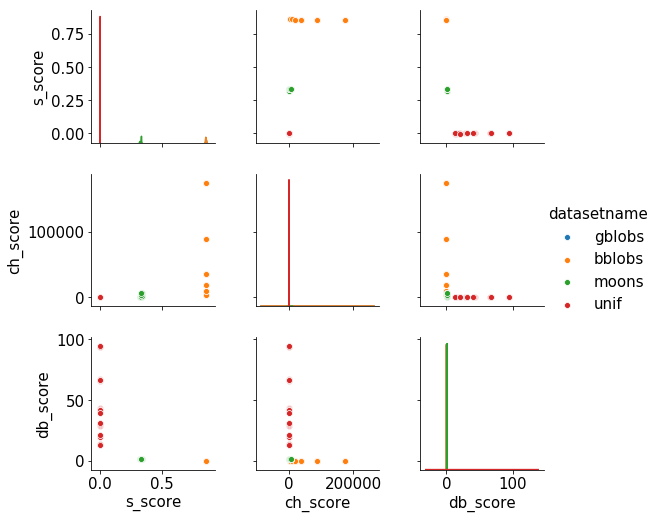

In [145]:
sns.pairplot(df,hue='datasetname',vars=['s_score','ch_score','db_score'])

Influence du nombre de points
------------------------------

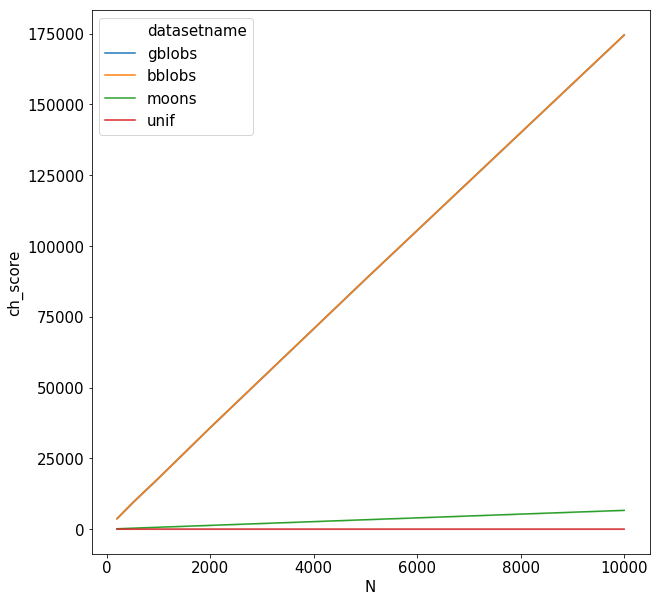

In [146]:
sns.lineplot(x='N',y='ch_score',hue='datasetname',data=df)

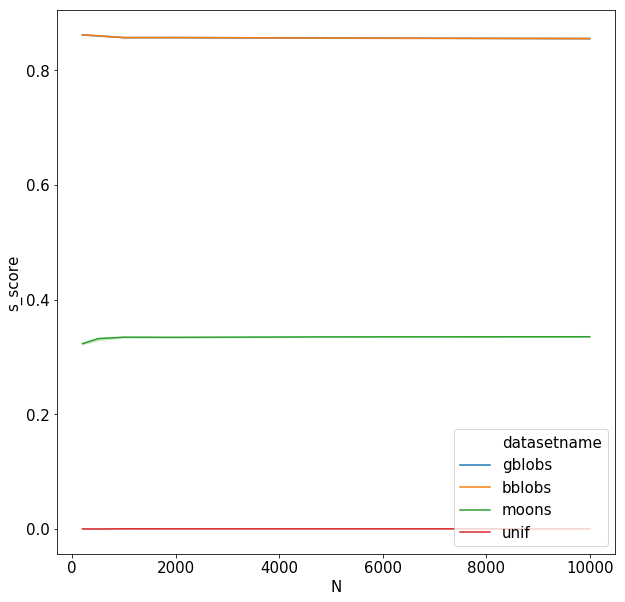

In [147]:
sns.lineplot(x='N',y='s_score',hue='datasetname',data=df)

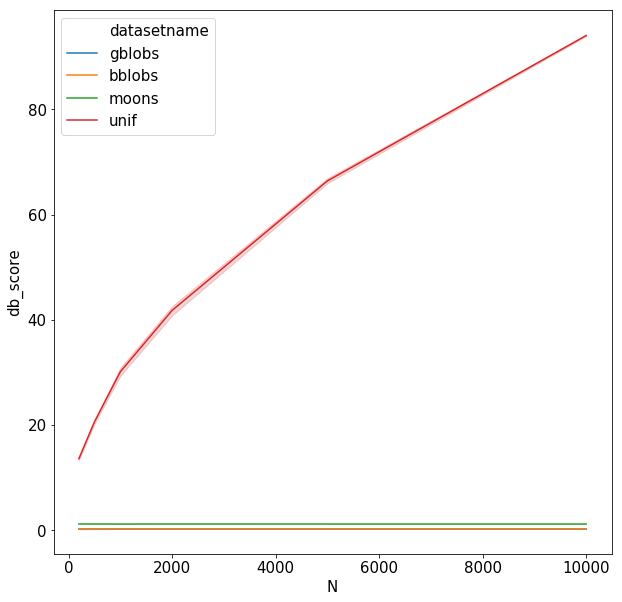

In [148]:
sns.lineplot(x='N',y='db_score',hue='datasetname',data=df)

Conclusion: le nombre de point n'a pas d'influence sur le score de silhouette et sur le score de Davies-Bouldin.
En revanche, le score de Calinski-Harabasz croit linéairement avec le nombre de point.
Il faudra donc faire attention à ne pas préférer à tord une méthode, ou un nombre de cluster, alors que l'améliore des scores n'est qu'un effet du nombre de points.

Utilisation pour choisir le nombre de clusters
-------------------------------------------------------------------


In [19]:
from sklearn.cluster import KMeans

### Cas facile : "good blobs"

In [149]:
K_values = np.arange(2,18)
silh=[]
ch=[]
db=[]
for k in K_values:
    km=KMeans(n_clusters=k)
    km.fit(X_gblobs)
    silh.append(silhouette_score(X_gblobs,km.labels_))
    ch.append(calinski_harabaz_score(X_gblobs,km.labels_))
    with np.errstate(divide='ignore'):
        db.append(davies_bouldin_score(X_gblobs,km.labels_))

Silhouette max= 0.857032344145763
Calinski-Harabasz max= 17945.953070073218
Davies-Bouldin min= 0.20287359839398003


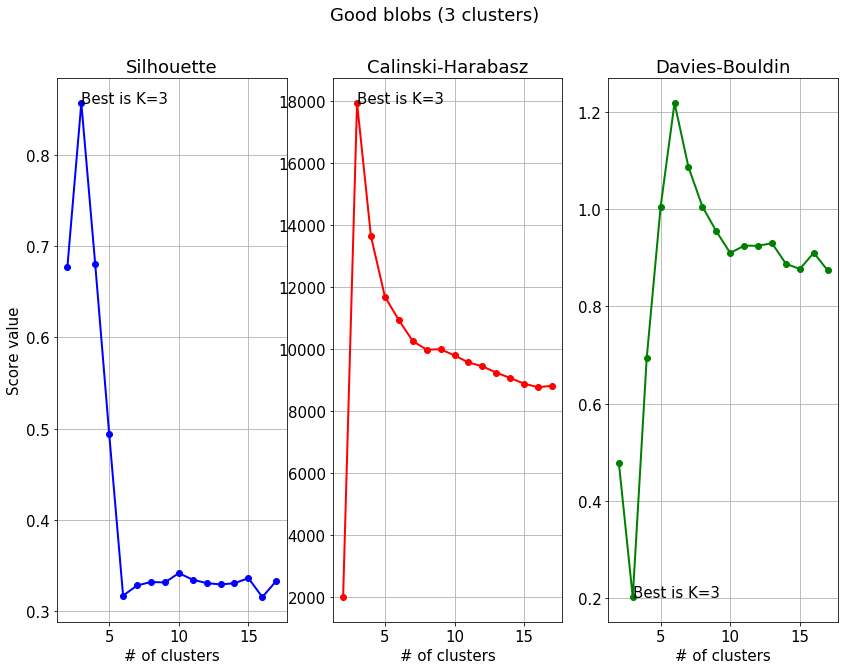

In [150]:
fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(14,10))
axs[0].plot(K_values,silh,'b-o',linewidth=2)
kopt=np.argmax(silh)+2
print("Silhouette max=",silh[kopt-2])
axs[0].text(x=kopt,y=silh[kopt-2],s="Best is K={}".format(kopt))
axs[0].set_title("Silhouette")
axs[0].set_xlabel("# of clusters")
axs[0].set_ylabel("Score value")
axs[0].grid(True)


axs[1].plot(K_values,ch,'r-o',linewidth=2,label="Best is K={}".format(np.argmax(ch)+2))
kopt=np.argmax(ch)+2
print("Calinski-Harabasz max=",ch[kopt-2])
axs[1].text(x=kopt,y=ch[kopt-2],s="Best is K={}".format(kopt))
axs[1].set_title("Calinski-Harabasz")
axs[1].set_xlabel("# of clusters")
axs[1].grid(True)


axs[2].plot(K_values,db,'g-o',linewidth=2,label="Best is K={}".format(np.argmin(db)+2))
kopt=np.argmin(db)+2
print("Davies-Bouldin min=",db[kopt-2])
axs[2].text(x=kopt,y=db[kopt-2],s="Best is K={}".format(kopt))
axs[2].set_title("Davies-Bouldin")
axs[2].set_xlabel("# of clusters")
axs[2].grid(True)

plt.suptitle("Good blobs (3 clusters)")
plt.show(block=False)

Conclusion : tous les scores donnent bien 3 clusters comme le choix optimal

### "Bad blobs"

In [151]:
K_values = np.arange(2,18)
silh=[]
ch=[]
db=[]
for k in K_values:
    km=KMeans(n_clusters=k)
    km.fit(X_bblobs)
    silh.append(silhouette_score(X_bblobs,km.labels_))
    ch.append(calinski_harabaz_score(X_bblobs,km.labels_))
    with np.errstate(divide='ignore'):
        db.append(davies_bouldin_score(X_bblobs,km.labels_))

Silhouette max= 0.7630112185928326
Calinski-Harabasz max= 6682.717312423603
Davies-Bouldin min= 0.31643216525664786


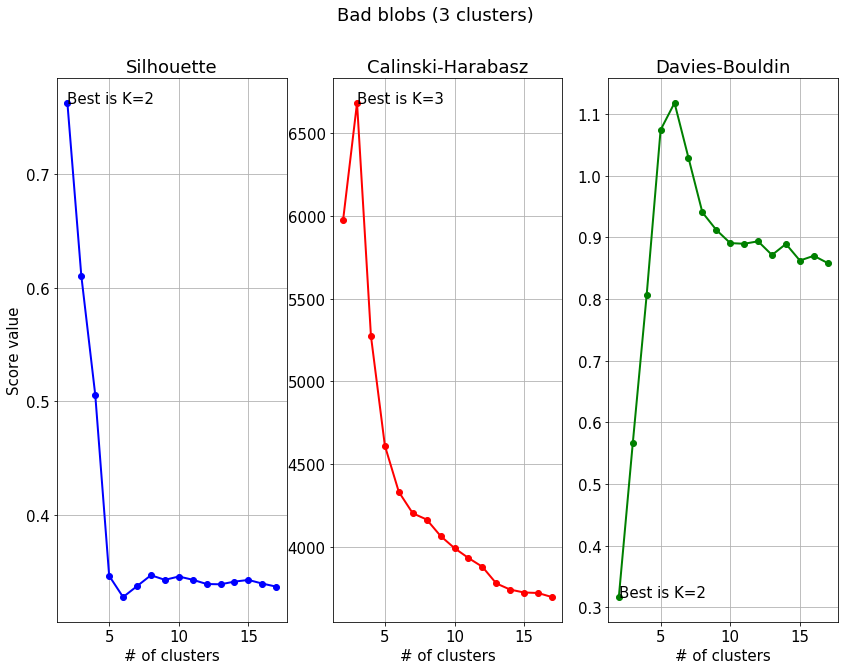

In [152]:
fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(14,10))
axs[0].plot(K_values,silh,'b-o',linewidth=2)
kopt=np.argmax(silh)+2
print("Silhouette max=",silh[kopt-2])
axs[0].text(x=kopt,y=silh[kopt-2],s="Best is K={}".format(kopt))
axs[0].set_title("Silhouette")
axs[0].set_xlabel("# of clusters")
axs[0].set_ylabel("Score value")
axs[0].grid(True)


axs[1].plot(K_values,ch,'r-o',linewidth=2,label="Best is K={}".format(np.argmax(ch)+2))
kopt=np.argmax(ch)+2
print("Calinski-Harabasz max=",ch[kopt-2])
axs[1].text(x=kopt,y=ch[kopt-2],s="Best is K={}".format(kopt))
axs[1].set_title("Calinski-Harabasz")
axs[1].set_xlabel("# of clusters")
axs[1].grid(True)


axs[2].plot(K_values,db,'g-o',linewidth=2,label="Best is K={}".format(np.argmin(db)+2))
kopt=np.argmin(db)+2
print("Davies-Bouldin min=",db[kopt-2])
axs[2].text(x=kopt,y=db[kopt-2],s="Best is K={}".format(kopt))
axs[2].set_title("Davies-Bouldin")
axs[2].set_xlabel("# of clusters")
axs[2].grid(True)
plt.suptitle("Bad blobs (3 clusters)")
plt.show(block=False)

Conclusion : silhouette et Davies-Bouldin donnent 2 clusters comme choix optimal, Calinski-Harabasz donne 3

### "Moons"

In [153]:
K_values = np.arange(2,18)
silh=[]
ch=[]
db=[]
for k in K_values:
    km=KMeans(n_clusters=k)
    km.fit(X_moons)
    silh.append(silhouette_score(X_moons,km.labels_))
    ch.append(calinski_harabaz_score(X_moons,km.labels_))
    with np.errstate(divide='ignore'):
        db.append(davies_bouldin_score(X_moons,km.labels_))

Silhouette max= 0.5258029464567933
Calinski-Harabasz max= 4180.0478402479075
Davies-Bouldin min= 0.5565213993237472


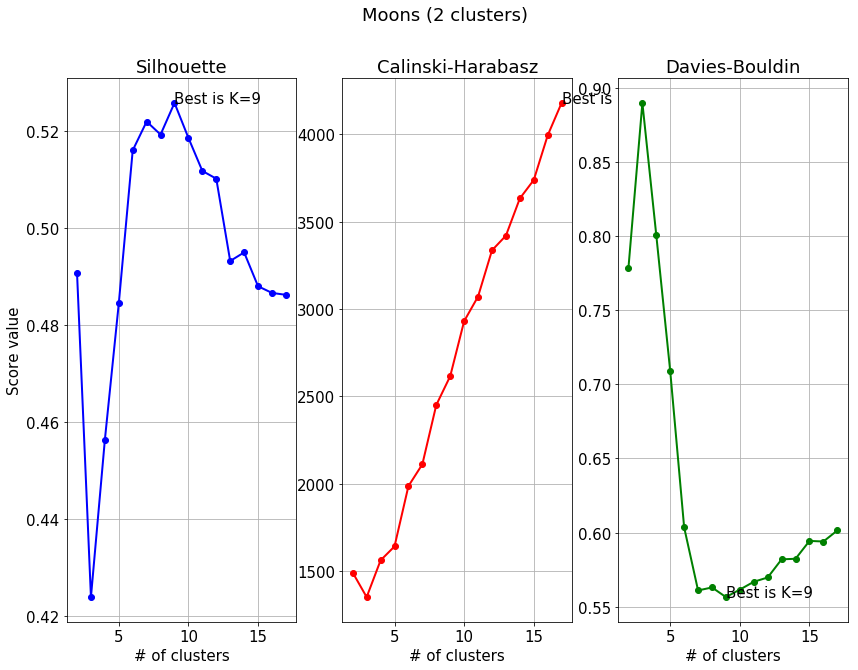

In [154]:
fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(14,10))
axs[0].plot(K_values,silh,'b-o',linewidth=2)
kopt=np.argmax(silh)+2
print("Silhouette max=",silh[kopt-2])
axs[0].text(x=kopt,y=silh[kopt-2],s="Best is K={}".format(kopt))
axs[0].set_title("Silhouette")
axs[0].set_xlabel("# of clusters")
axs[0].set_ylabel("Score value")
axs[0].grid(True)


axs[1].plot(K_values,ch,'r-o',linewidth=2,label="Best is K={}".format(np.argmax(ch)+2))
kopt=np.argmax(ch)+2
print("Calinski-Harabasz max=",ch[kopt-2])
axs[1].text(x=kopt,y=ch[kopt-2],s="Best is K={}".format(kopt))
axs[1].set_title("Calinski-Harabasz")
axs[1].set_xlabel("# of clusters")
axs[1].grid(True)


axs[2].plot(K_values,db,'g-o',linewidth=2,label="Best is K={}".format(np.argmin(db)+2))
kopt=np.argmin(db)+2
print("Davies-Bouldin min=",db[kopt-2])
axs[2].text(x=kopt,y=db[kopt-2],s="Best is K={}".format(kopt))
axs[2].set_title("Davies-Bouldin")
axs[2].set_xlabel("# of clusters")
axs[2].grid(True)

plt.suptitle("Moons (2 clusters)")
plt.show(block=False)

Conclusion : tous les scores montrent une amélioration lorsque le nombre de cluster augmente. Or il y a clairement deux clusters dans les données, que les K-means seront incapables de séparer (frontières non-linéaires).
Ce résultat tend à montrer que, lorsque l'algorithme n'est pas capable de séparer les données correctement, les scores donnent pour optimal un nombre de clusters bien plus grand que le nombre de clusters "naturels".
La valeur des scores optimaux est aussi très différente de ce que l'on a avec un dataset plus facile à partitionner.

### Uniform

In [155]:
K_values = np.arange(2,18)
silh=[]
ch=[]
db=[]
for k in K_values:
    km=KMeans(n_clusters=k)
    km.fit(X_unif)
    silh.append(silhouette_score(X_unif,km.labels_))
    ch.append(calinski_harabaz_score(X_unif,km.labels_))
    with np.errstate(divide='ignore'):
        db.append(davies_bouldin_score(X_unif,km.labels_))

Silhouette max= 0.001388539379771859
Calinski-Harabasz max= 2.3924487367022875
Davies-Bouldin min= 10.1995967500666


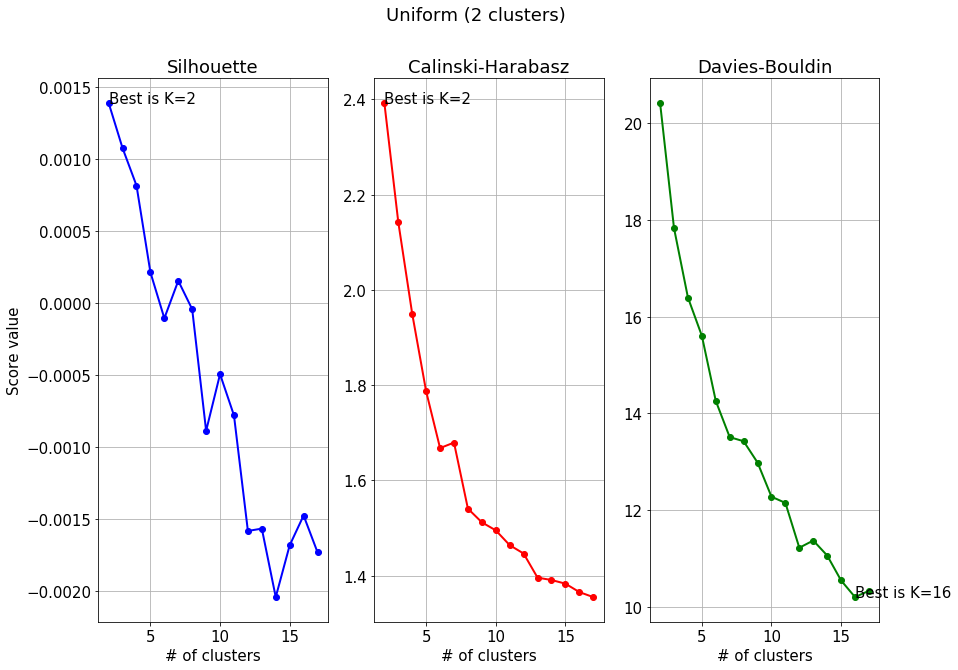

In [156]:
fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(14,10))
axs[0].plot(K_values,silh,'b-o',linewidth=2)
kopt=np.argmax(silh)+2
print("Silhouette max=",silh[kopt-2])
axs[0].text(x=kopt,y=silh[kopt-2],s="Best is K={}".format(kopt))
axs[0].set_title("Silhouette")
axs[0].set_xlabel("# of clusters")
axs[0].set_ylabel("Score value")
axs[0].grid(True)


axs[1].plot(K_values,ch,'r-o',linewidth=2,label="Best is K={}".format(np.argmax(ch)+2))
kopt=np.argmax(ch)+2
print("Calinski-Harabasz max=",ch[kopt-2])
axs[1].text(x=kopt,y=ch[kopt-2],s="Best is K={}".format(kopt))
axs[1].set_title("Calinski-Harabasz")
axs[1].set_xlabel("# of clusters")
axs[1].grid(True)


axs[2].plot(K_values,db,'g-o',linewidth=2,label="Best is K={}".format(np.argmin(db)+2))
kopt=np.argmin(db)+2
print("Davies-Bouldin min=",db[kopt-2])
axs[2].text(x=kopt,y=db[kopt-2],s="Best is K={}".format(kopt))
axs[2].set_title("Davies-Bouldin")
axs[2].set_xlabel("# of clusters")
axs[2].grid(True)

plt.suptitle("Uniform (2 clusters)")
plt.show(block=False)

La silhouette et Calinski-Harabasz donnent 2 clusters alors que Davies-Bouldin en donne 16.
Or il n'y a aucun cluster à trouver dans ce jeu de donnée : il n'y a finalement qu'un seul cluster, que l'algorithme des Kmeans divise et redivise...
Cette division a pour effet de dégrader le score de silhouette et de Calinski-Harabasz et d'améliorer le score de Davies-Bouldin.

Jeu de donnée de type 'profil'
===========================
Certains problèmes de classifications consistent à regrouper les points d'une série de mesures d'affilée (des profils mesurés par satellite ou autre moyen de télédétection, par exemple).
Le problème des ce type de jeu de donnée et leur caractère continu, filandreux.
Nous allons voir comment se comportent les scores de classification avec ces jeux de données.

Création du profil
------------------
On simule des données $c(z)$ où $c$ est une quantité mesurée et $z$ est l'altitude.

In [32]:
zmin=10
zmax=3000
N=600
z=np.linspace(zmin,zmax,N)
zi=1000
steep=300
amp=2
sig=0.01
c=amp*((np.pi/2-np.arctan((z-zi)/steep))/np.pi+sig*np.random.randn(N))
cs=amp*((np.exp(-(z-zi)/(1.05*steep))/(1+np.exp(-(z-zi)/steep)))+sig*np.random.randn(N))

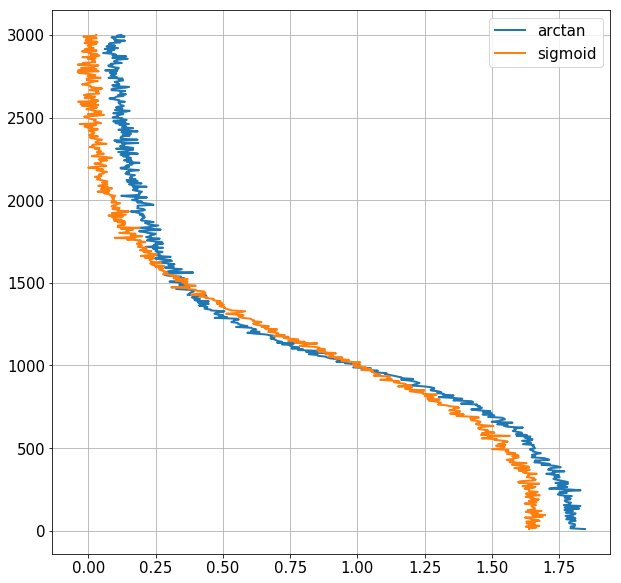

In [33]:
plt.figure()
plt.plot(c,z,linewidth=2,label="arctan")
plt.plot(cs,z,linewidth=2,label="sigmoid")
plt.grid()
plt.legend()

In [34]:
def profile_arctan(N=600,zi=1000,steep=300,amp=1,sig=0,zmin=30,zmax=3000,return_labels=False):
    '''Simulate a vertical profile of concentration with arctan function.
    
    [IN]
        - N (int): number of points in the profile
        - zi (float): altitude of the concentration limit
        - steep (float): slope at the concentration limit
        - amp (float): amplitude, maximum concentration in the profile
        - sig (float): noise standard deviation
        - zmin (float): minimum altitude
        - zmax (float): maximum altitude
        
    [OUT]
        - z (np.array[N]): vector of altitudes
        - c (np.array[N]): vector of concentrations
        - lab (np.array[N]): vector of labels'''
    
    z=np.linspace(zmin,zmax,N)
    c=amp*((np.pi/2-np.arctan((z-zi)/steep))/np.pi+sig*np.random.randn(N))
    
    if return_labels:
        lab=np.zeros(N,dtype=int)
        lab[z>zi]=1
        result=c,z,lab
    else:
        result=c,z
    
    return result

In [35]:
def profile_sigmoid(N=600,zi=1000,steep=300,amp=1,sig=0,zmin=30,zmax=3000,return_labels=False):
    '''Simulate a vertical profile of concentration with sigmoid function.
    
    [IN]
        - N (int): number of points in the profile
        - zi (float): altitude of the concentration limit
        - steep (float): slope at the concentration limit
        - amp (float): amplitude, maximum concentration in the profile
        - sig (float): noise standard deviation
        - zmin (float): minimum altitude
        - zmax (float): maximum altitude
        
    [OUT]
        - z (np.array[N]): vector of altitudes
        - c (np.array[N]): vector of concentrations
        - lab (np.array[N]): vector of labels'''
    
    z=np.linspace(zmin,zmax,N)
    c=amp*((np.exp(-(z-zi)/(1.05*steep))/(1+np.exp(-(z-zi)/steep)))+sig*np.random.randn(N))
    
    if return_labels:
        lab=np.zeros(N,dtype=int)
        lab[z>zi]=1
        result=c,z,lab
    else:
        result=c,z
    
    return result

In [36]:
c,z,lab=profile_arctan(sig=0.05,return_labels=True)

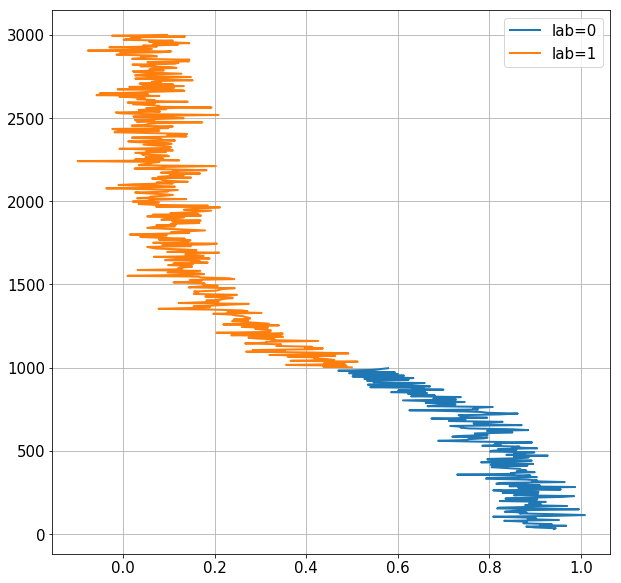

In [37]:
plt.figure()
for k in np.unique(lab):
    plt.plot(c[lab==k],z[lab==k],linewidth=2,label="lab="+str(k))
plt.grid()
plt.legend()

Calcul des scores sur le profil
---------------------------------------
Test pour un profil avec une transition très nette et un autre avec une transition beaucoup plus lisse.

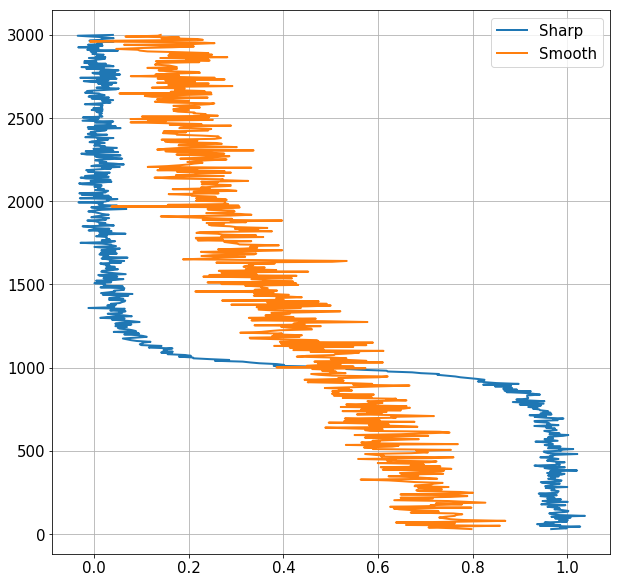

In [38]:
c_gp,z_gp,lab_gp=profile_arctan(steep=50,sig=0.02,return_labels=True)
c_bp,z_bp,lab_bp=profile_arctan(steep=1000,sig=0.06,return_labels=True)

plt.figure()
plt.plot(c_gp,z_gp,linewidth=2,label="Sharp")
plt.plot(c_bp,z_bp,linewidth=2,label="Smooth")
plt.grid()
plt.legend()

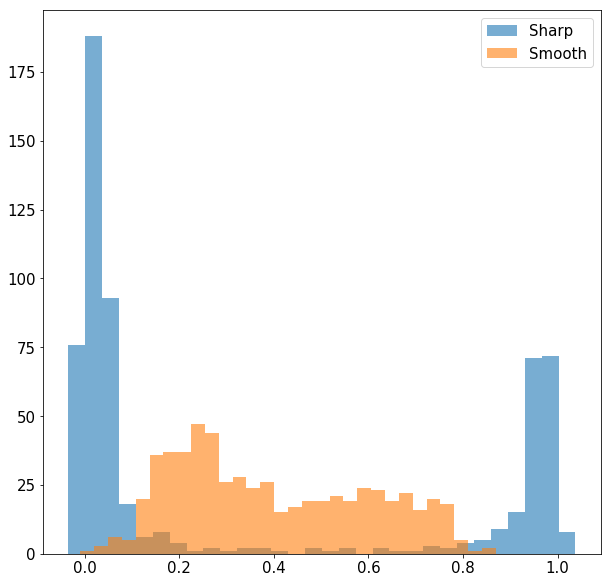

In [39]:
plt.figure()
plt.hist(c_gp,30,alpha=0.6,label="Sharp")
plt.hist(c_bp,30,alpha=0.6,label="Smooth")
plt.legend()

In [40]:
c_gp=c_gp.reshape((-1,1))
c_bp=c_bp.reshape((-1,1))

In [41]:
print("Score of SHARP profile:")
print(" - Silhouette",silhouette_score(c_gp,lab_gp))
print(" - Calinski-Harabasz",calinski_harabaz_score(c_gp,lab_gp))
with np.errstate(divide='ignore'):
    print(" - Davies-Bouldin",davies_bouldin_score(c_gp,lab_gp))

Score of SHARP profile:
 - Silhouette 0.9246804803251529
 - Calinski-Harabasz 20172.07453220817
 - Davies-Bouldin 0.10051856886574093


In [42]:
print("Score of SMOOTH profile:")
print(" - Silhouette",silhouette_score(c_bp,lab_bp))
print(" - Calinski-Harabasz",calinski_harabaz_score(c_bp,lab_bp))
with np.errstate(divide='ignore'):
    print(" - Davies-Bouldin",davies_bouldin_score(c_bp,lab_bp))

Score of SMOOTH profile:
 - Silhouette 0.6030109992512065
 - Calinski-Harabasz 1443.7131212698523
 - Davies-Bouldin 0.47343254069162033


Sur exemple, on voit que les scores du profil lisse sont bien moins bons que ceux du profil tranché.
Cela tend à prouver que les scores reflètent bien le caractère séparables des modes que nous observons dans les histogrammes plus hauts.
Pour confirmer ce résultat, nous allons faire une analyse de sensibilité.

Sensibilité des scores aux caractéristiques du profils
--------------------------------------------------
L'analyse de sensibilité se déroule de la façon suivante :
  1. Lister les paramètres à inclure dans l'analyse
  2. Définir des bornes admissibles pour les valeurs
  3. Echantilloner l'ensemble des valeurs possibles pour chacun des paramètres
  4. Calculer les scores de classification pour chaque jeu de paramètres
  5. Analyser les résultats (graphiques, estimations d'indices de Sobol...)

### Liste des paramètres
Les paramètres soumis à l'analyse de sensibilité sont
  * `steep`: le caractère tranché (a contratio, lisse) du profil
  * `amp`: l'amplitude de la variation de concentration
  * `sig`: l'écart-type du bruit de mesure
  * `zi`: la hauteur qui sépare les deux classes

In [43]:
def classif_scores_on_profile(zi,steep,amp,sig,profile_type='arctan',score_names=['sil','ch','db']):
    '''Estimate the classification scores on a profile-like dataset.
    
    [IN]
        - zi (float): altitude of the concentration limit
        - steep (float): slope at the concentration limit
        - amp (float): amplitude, maximum concentration in the profile
        - sig (float): noise standard deviation
        - profile_type (str): function used to simulate the profile. Must be in ['arctan','sigmoid']
        - score_names (list of str): abbreviations of classification scores to be calculated
            'sil' stands for silhouette score
            'ch' stands for Calinski-Harabasz score
            'db' stands for Davies-Bouldin score
        
    [OUT]
        - (tuple of float): tuple of scores listed in score_names'''
    
    
    if profile_type=='arctan':
        c,z,lab=profile_arctan(zi=zi,steep=steep,amp=amp,sig=sig,return_labels=True)
    elif profile_type=='sigmoid':
        c,z,lab=profile_sigmoid(zi=zi,steep=steep,amp=amp,sig=sig,return_labels=True)
    else:
        raise ValueError("Unknown profile type. profile_type must be in ['arctan','sigmoid']")
    
    result=[]
    if 'sil' in score_names:
        result.append(silhouette_score(c.reshape((-1,1)),lab))
    if 'ch' in score_names:
        result.append(calinski_harabaz_score(c.reshape((-1,1)),lab))
    if 'db' in score_names:
        with np.errstate(divide='ignore'):
            result.append(davies_bouldin_score(c.reshape((-1,1)),lab))
    
    return result

### Bornes de variations

In [44]:
zi_bounds = [50,2500]
steep_bounds = [30,800]
amp_bounds = [0.1,30]
sig_bounds = [0,0.15]

### Echantillonage des valeurs possibles
Nous utiliserons un package dédié à l'analyse de sensibilité : `SALib`.
Ce package permet non seulement de faire l'échantillonage (de façon optimiser pour l'estimation d'indices de sensibilité) mais aussi de calculer ces indices de sensibilité.

In [45]:
from SALib.sample import saltelli

In [46]:
# For SALib functions
namesInput = ['zi','steep','amp','sig']
M=3000
problem = {
    'num_vars': len(namesInput),
    'names': namesInput,
    'bounds': [zi_bounds,steep_bounds,amp_bounds,sig_bounds]}

In [47]:
X=saltelli.sample(problem,M)
X.shape

(30000, 4)

La matrice `X` contient 4 colonnes et beaucoup de lignes : chaque colonne correspond à un des paramètres d'entrée listés et chaque ligne correspond à une valeur pour chacun des paramètres.
L'échantillonnage est tel que tous les paramètres varient en même temps et de façon à couvrir l'ensemble de domaine admissible (quasi-Monte Carlo).

### Calculer les scores de classification pour chaque jeu de paramètres

In [48]:
def loop_classifscores(X,profile_type='arctan',score_names=['sil','ch','db']):
    
    M,p = X.shape
    scores = []
    for i in range(M):
        scores.append(classif_scores_on_profile(zi=X[i,0],steep=X[i,1],amp=X[i,2],sig=X[i,3],profile_type=profile_type,score_names=score_names))
        
    return np.array(scores)

In [49]:
y = loop_classifscores(X)
y.shape

(30000, 3)

La matrice `y` contient 3 colonnes et beaucoup de lignes.
Chaque colonne correspons à un score de classification et chaque ligne correspond à leurs valeurs obtenues avec le profil généré avec les paramètres donnés dans `X`.

### Analyse globale des résultats
Pour faire une analyse globale les résultats, nous allons estimer les indices de Sobol.
Il s'agit d'indices de sensibilité qui permettent de résumer l'influence des paramètres d'un code.
Les indices de Sobol sont compris entre 0 et 1 : plus ils sont importants, plus le paramètre corresponda a de l'influence.

#### Estimation des indices de Sobol

In [50]:
from SALib.analyze import sobol

In [51]:
Si = sobol.analyze(problem, y[:,0], print_to_console=False)

In [52]:
Si

{'S1': array([9.36483463e-02, 5.91878958e-01, 2.71731345e-04, 2.82216592e-01]),
 'S1_conf': array([0.01892431, 0.03434236, 0.00503607, 0.0249012 ]),
 'ST': array([0.11477338, 0.62614133, 0.01236945, 0.30642039]),
 'ST_conf': array([0.00989383, 0.03296133, 0.00185929, 0.0190479 ]),
 'S2': array([[        nan,  0.00665041, -0.00986893, -0.00676538],
        [        nan,         nan,  0.00490025,  0.0081653 ],
        [        nan,         nan,         nan,  0.00277765],
        [        nan,         nan,         nan,         nan]]),
 'S2_conf': array([[       nan, 0.03049327, 0.02846021, 0.03498579],
        [       nan,        nan, 0.04324048, 0.05526465],
        [       nan,        nan,        nan, 0.00812877],
        [       nan,        nan,        nan,        nan]])}

La fonction `SALib.analyze.sobol.analyze` renvoit un dictionnaire avec 6 champs.
Les clés sont des chaines de caractères et les valeurs sont des `numpy.array` de dimension 1 ou 2.
  * `S1` donne les indices de Sobol simples d'ordre 1. Il y a une valeur par paramètre d'entrée, qui correspond à l'influence de ce paramètre seulement.
  * `S1_conf` donne l'intervalle de confiance à 95% de l'estimation des indices de Sobol simples d'ordre 1 (la valeur donnée est 1.96$\sigma_e$ avec $\sigma_e$ l'écart-type de l'estimateur, supposé gaussien)
  * `ST` donne les indices de Sobol totaux d'ordre 1. Il y a une valeur par paramètre d'entrée, qui correspond à l'influence de ce paramètre en incluant toutes ses interactions.
  * `ST_conf` donne l'intervalle de confiance à 95% de l'estimation des indices de Sobol totaux d'ordre 1 (la valeur donnée est 1.96$\sigma_e$ avec $\sigma_e$ l'écart-type de l'estimateur, supposé gaussien)
  * `S2` donne les indices de Sobol simples d'ordre 2. C'est une matrice de taille $p \times p$ où $p$ est le nombre de paramètres. Seuls les éléments du triangle supérieur (hors diagonale) sont remplis. Il correspondent à l'influence de l'interaction de chaque paire de paramètres (ils n'incluent pas l'influence qu'ils ont seuls).
  * `S2_conf` donne l'intervalle de confiance à 95% de l'estimation des indices de Sobol simples d'ordre 2 (la valeur donnée est 1.96$\sigma_e$ avec $\sigma_e$ l'écart-type de l'estimateur, supposé gaussien)

#### Représentation des indices de Sobol d'ordre 1

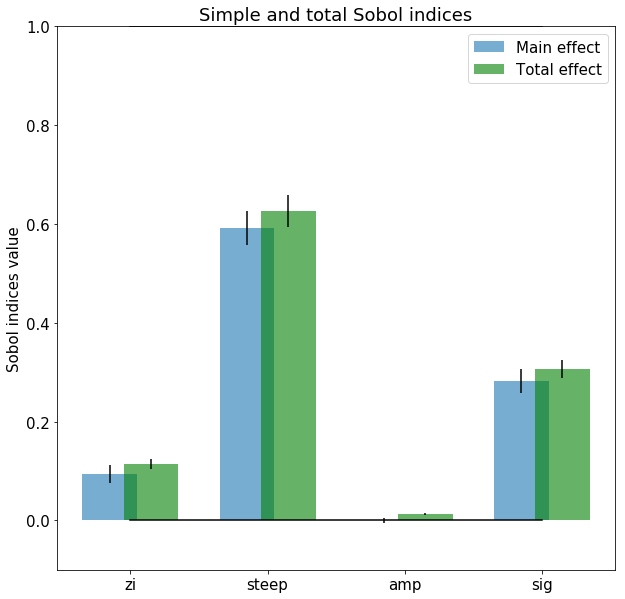

In [53]:
nP=len(namesInput)
xPos = 2*np.arange(nP)
dx = 0.3

plt.figure()
plt.title("Simple and total Sobol indices")
plt.bar(xPos-dx, Si['S1'],yerr=Si['S1_conf'], align='center', alpha=0.6,label="Main effect")
plt.bar(xPos+dx, Si['ST'],yerr=Si['ST_conf'], align='center', color='green', alpha=0.6,label="Total effect")
plt.xticks(xPos, namesInput,fontsize=15)
plt.ylim((-0.1,1))
plt.ylabel("Sobol indices value")
plt.legend()
plt.plot(xPos,np.ones(nP),'k-')
plt.plot(xPos,np.zeros(nP),'k-')
plt.show(block=False)

Les barres vertes correspondent aux indices de Sobol totaux d'ordre 1 (influence incluant toutes les interactions).
Les barres bleues correspondent aux indices de Sobol simples d'ordre 1 (influence seul).
Il y a une barre verte et une barre bleue pour chaque paramètre d'entrée.
La barre verte doit être supérieure à la barre bleue et les valeurs doivent être comprises entre 0 et 1.
Si ce n'est pas le cas, c'est surement que le nombre de valeurs testées `M` est trop petit (ODG ~ 10000).

On voit nettement une hiérarchie d'influence entre les paramètres :
  1. `steep`
  2. `sig`
  3. `zi`
  4. `amp` (aucune influence)

Ils ont très peu d'interaction entre eux (différences faibles entre indices simples et totaux).

#### Représentation des indices d'ordre 2
On commence par compléter la matrice retournée par la fonction : symétrisation et ajout de la part d'intéraction (indice total - indice simple) sur la diagonale.

In [54]:
Si['S2'][np.isnan(Si['S2'])]=0
Si['S2']=Si['S2']+Si['S2'].T
for k in range(nP):
    Si['S2'][k,k]=Si['ST'][k]-Si['S1'][k]
Si['S2']

array([[ 0.02112503,  0.00665041, -0.00986893, -0.00676538],
       [ 0.00665041,  0.03426237,  0.00490025,  0.0081653 ],
       [-0.00986893,  0.00490025,  0.01209772,  0.00277765],
       [-0.00676538,  0.0081653 ,  0.00277765,  0.0242038 ]])

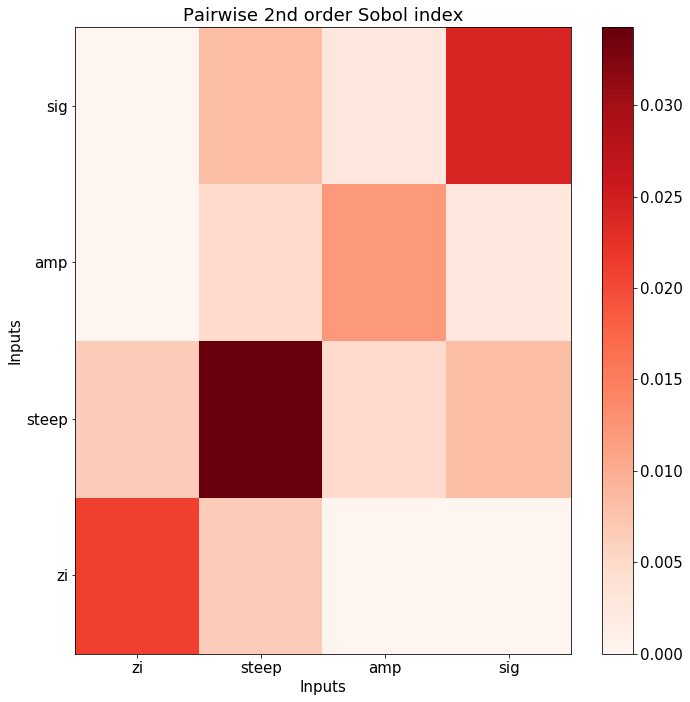

In [55]:
xPos=np.arange(nP+1)
yPos=np.arange(nP+1)
large = 0.5
#-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
fig=plt.figure()
plt.title("Pairwise 2nd order Sobol index")
plt.pcolormesh(xPos,yPos,Si['S2'],cmap='Reds',vmin=0)
plt.xticks(xPos[1:]-large, namesInput,fontsize=15)
plt.yticks(yPos[1:]-large, namesInput,fontsize=15)
plt.xlabel("Inputs")
plt.ylabel("Inputs")
plt.colorbar()
plt.tight_layout()
plt.show(block=False)
#-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-

Ce graphique représente la matrice que nous avons complété.
Les éléments diagonaux correspondent à la part d'interaction dans l'influence du paramètre (plus elle est élevée, plus son influence est complexe).
Les éléments hors diagonale correspondent à l'indice de Sobol d'ordre 2 : plus ils sont élevés, plus cette paire de paramètres a de l'influence.

On note deux interactions hors diagonale `steep,zi` et `steep,sig`.
On les retrouve aussi dans la part d'interaction (éléments diagonaux) de `zi`, `sig` et `steep`.
Cela indique que les interactions entre les paramètres se font essentiellement par paire.
De plus, les valeurs des indices restent très faibles, donc on peut se limiter à l'influence à l'ordre 1.

#### Représentation synthétique sous forme de graphe
Pour représenter à la fois les indices d'ordre 1 et les indices d'ordre 2, on peut placer les paramètres d'entrée sur un graphe dont les arrêtes représente les interations significatives (i.e. supérieure à un seuil) et dont le diamètre du sommet représente l'influence du paramètre.
Nous commençons par créer le graphe en mettant un poids sur les arrêtes égal à l'indice de Sobol d'ordre 2.

In [62]:
import networkx as nx
G2S = nx.Graph()
thresholdInter=0.01
for in1 in range(nP):
	G2S.add_node(namesInput[in1])
print("G2S.nodes()=",G2S.nodes())

for in1 in range(nP):
	print(" --- in1 = ",namesInput[in1])
	G2S.add_edge(namesInput[in1],namesInput[in1],weight=max(0,Si['S2'][in1,in1]))
	for in2 in range(in1+1,nP):
		if Si['S2'][in1,in2]>=thresholdInter:
			print("      |--- in2 = ",namesInput[in2])
			G2S.add_edge(namesInput[in1],namesInput[in2],weight=max(0,Si['S2'][in1,in2]))
# Fill in the color_edge vector
color_edge = []
for j in G2S.edges():
	color_edge.append(G2S[j[0]][j[1]]['weight'])

G2S.nodes()= ['zi', 'steep', 'amp', 'sig']
 --- in1 =  zi
 --- in1 =  steep
 --- in1 =  amp
 --- in1 =  sig


In [63]:
nodesizeS=[]
nodesizeT=[]
for i in range(G2S.number_of_nodes()):
	print("Node",namesInput[i],": inner ring=",Si['S1'][i],"\t outer ring=",Si['ST'][i])
	nodesizeS.append(10000*max(0,Si['S1'][i])+1400)
	nodesizeT.append(10000*max(0,Si['ST'][i])+1400)

Node zi : inner ring= 0.09364834632350191 	 outer ring= 0.11477337950294512
Node steep : inner ring= 0.5918789578109674 	 outer ring= 0.6261413293000262
Node amp : inner ring= 0.00027173134468264337 	 outer ring= 0.012369454865159984
Node sig : inner ring= 0.28221659180814007 	 outer ring= 0.30642039419972195


Pour représenter l'influence d'un paramètre, on place au sommet du graphe deux disque concentriques :
  * Un disque intérieur, dont le diamètre est proportionel à l'indice de Sobol simple d'ordre 1
  * Un disque extérieur, dont le diamètre est proportionel à l'indice de Sobol total

/cnrm/lisa/conda3repertoire/anaconda3/envs/surpython/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


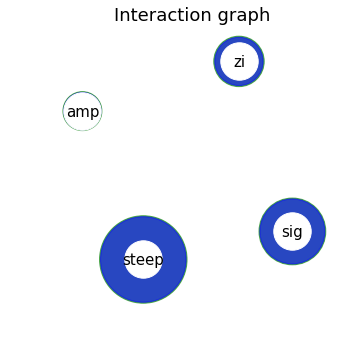

In [132]:
pos=nx.spring_layout(G2S)
dicNamesInput = {it:it for it in namesInput}
plt.figure(figsize=(5,5))
plt.title("Interaction graph")
nx.draw_networkx_nodes(G2S,pos,node_size=nodesizeT,node_color='green',alpha=0.6,label='In interaction')
nx.draw_networkx_nodes(G2S,pos,node_size=nodesizeS,node_color='blue',alpha=0.6,label='Alone')
nx.draw(G2S,pos,edge_color=color_edge,width=4,edge_cmap=plt.cm.Greens,edge_vmin=0,edge_vmax=0.02,node_size=1400,node_color='white')
nx.draw_networkx_labels(G2S,pos,labels=dicNamesInput,font_size=15)
#plt.legend(loc='best')
plt.tight_layout()
plt.show(block=False)

Sur le graphe, on retrouve toutes les caractérisques identifiées précédemment : les paramètres ont des influences inégales.
`steep` est le plus important, `sig` le second, `zi` le troisième, avec un part déjà limitée, et enfin `amp` qui n'a pas d'influence.
Ils ont peu d'interaction entre eux : agir sur un paramètre n'aura pas de conséquence sur les réglages des autres.

### Analyse détaillée des résultats
L'analyse détaillée consiste à expliciter comment les influences importantes que nous avons identifiés se manifestent (croissance, décroissance, de quelle ampleur...).
Pour cela nous commençons par stocker tous les résultats dans une dataframe.

In [65]:
AS=pd.DataFrame(columns=namesInput+['silh','ch','db'],data=np.concatenate([X,y],axis=1))

In [66]:
AS.head()

,zi,steep,amp,sig,silh,ch,db
0,588.330078,104.443359,15.604785,0.101514,0.800048,3289.892872,0.268663
1,736.669922,104.443359,15.604785,0.101514,0.799862,3904.640716,0.277302
2,588.330078,728.564453,15.604785,0.101514,0.519160,672.743413,0.562862
3,588.330078,104.443359,1.472363,0.101514,0.794257,3096.595172,0.276210
4,588.330078,104.443359,15.604785,0.134912,0.756587,2329.263002,0.327086


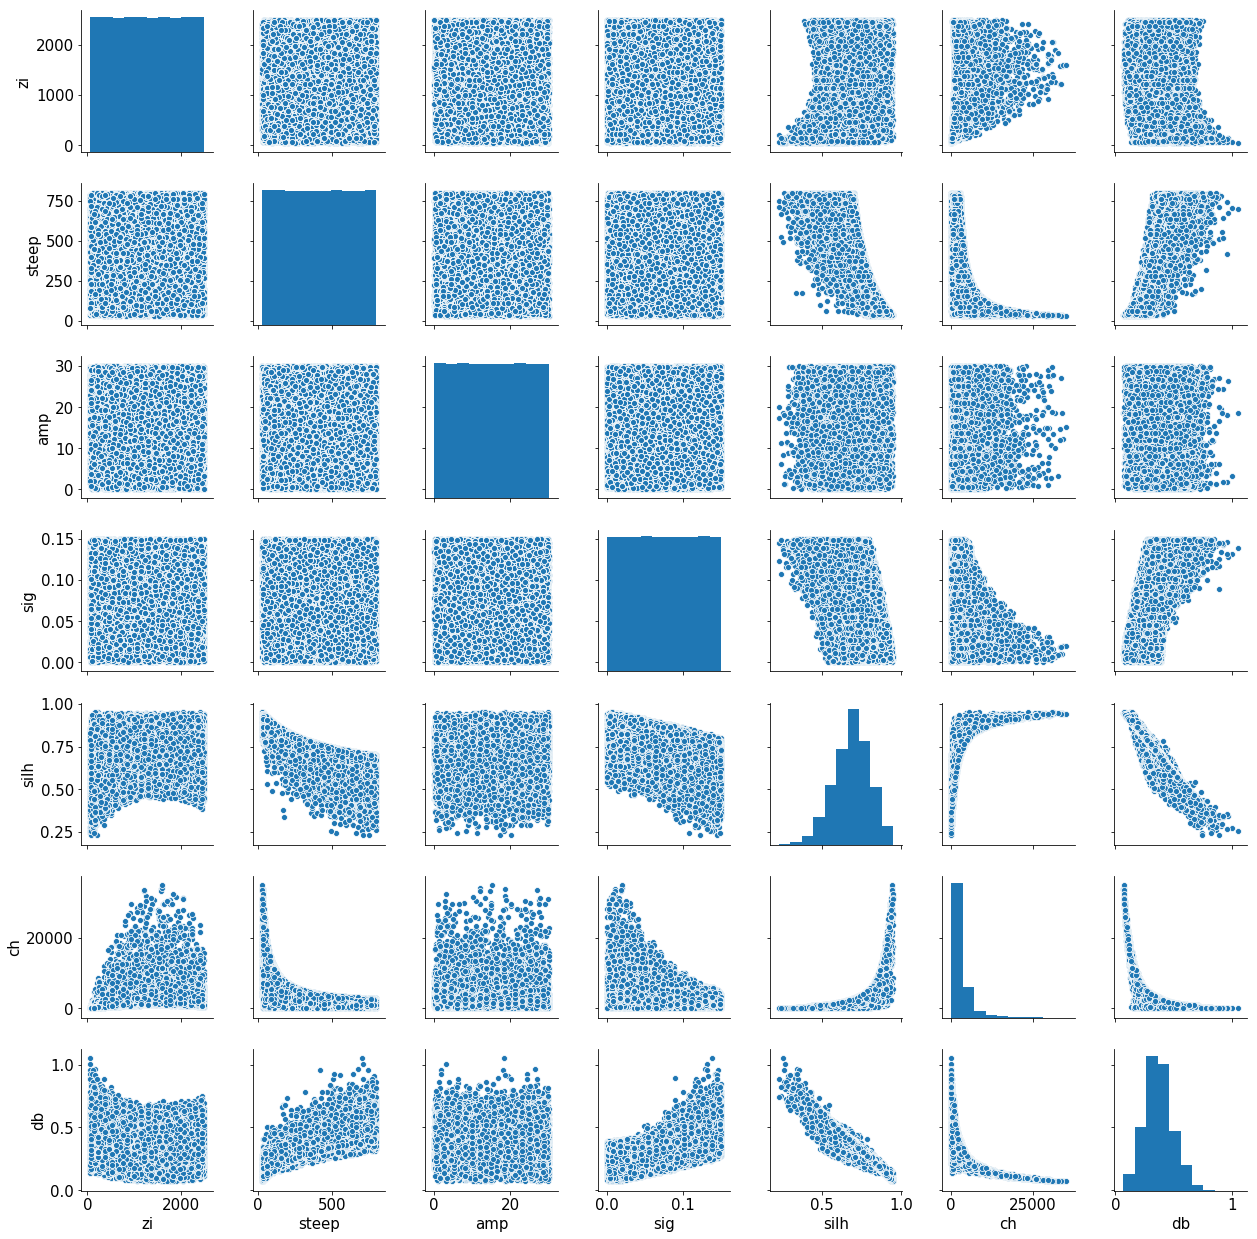

In [67]:
sns.pairplot(AS)

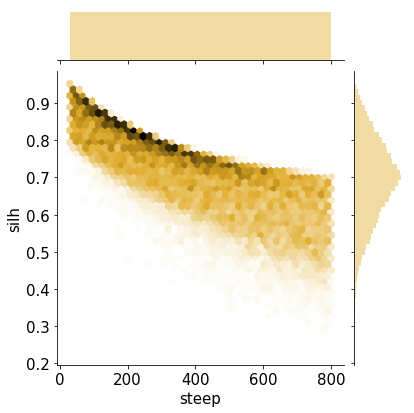

In [68]:
sns.jointplot(x='steep',y='silh',color='goldenrod',kind='hex',data=AS)

Text(0, 0.5, 'silh')

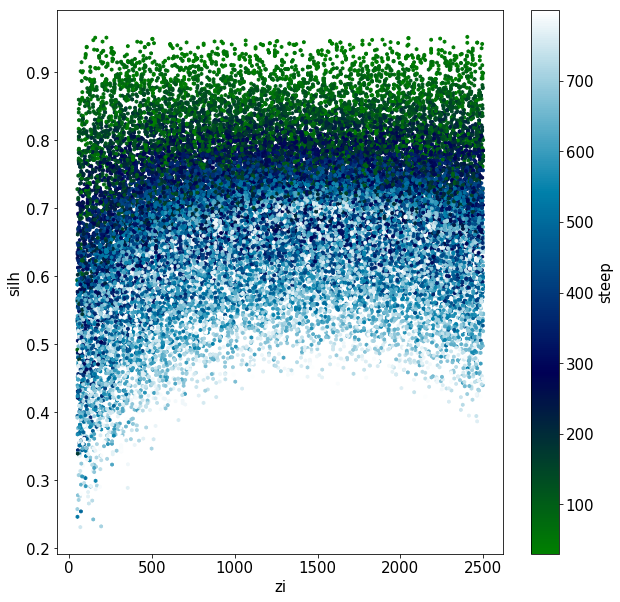

In [69]:
on_x='zi'
on_y='silh'
on_c='steep'

plt.figure(figsize=(10,10))
plt.scatter(AS[on_x],AS[on_y],c=AS[on_c],s=10,marker='h',edgecolors=None,cmap="ocean")
plt.colorbar(label=on_c)
plt.xlabel(on_x)
plt.ylabel(on_y)

Text(0, 0.5, 'ch')

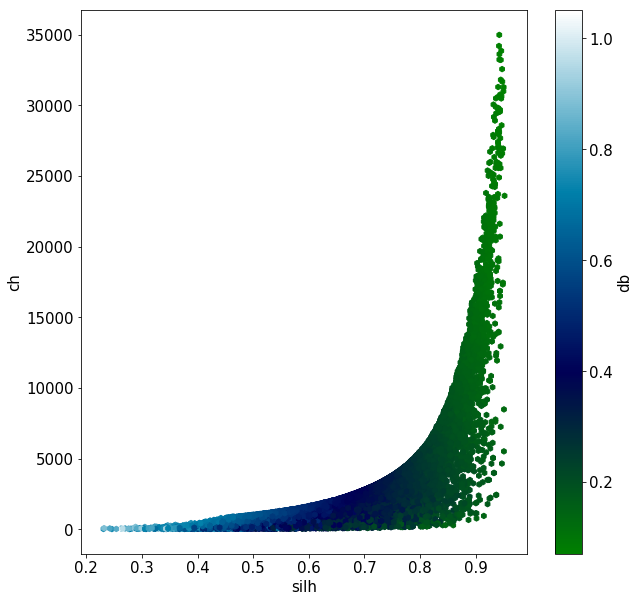

In [70]:
on_x='silh'
on_y='ch'
on_c='db'

plt.figure(figsize=(10,10))
plt.scatter(AS[on_x],AS[on_y],c=AS[on_c],s=30,marker='h',edgecolors=None,cmap="ocean")
plt.colorbar(label=on_c)
plt.xlabel(on_x)
plt.ylabel(on_y)

Peut-on utiliser ces scores pour écarter un algo de classification ?
-------------------------------------------------------------------------------

In [158]:
K_values = np.arange(2,18)
silh=[]
ch=[]
db=[]
for k in K_values:
    km=KMeans(n_clusters=k)
    km.fit(c_gp)
    silh.append(silhouette_score(c_gp,km.labels_))
    ch.append(calinski_harabaz_score(c_gp,km.labels_))
    with np.errstate(divide='ignore'):
        db.append(davies_bouldin_score(c_gp,km.labels_))

Silhouette max= 0.9246804803251529
Calinski-Harabasz max= 59550.42376478262
Davies-Bouldin min= 0.10051856886574093


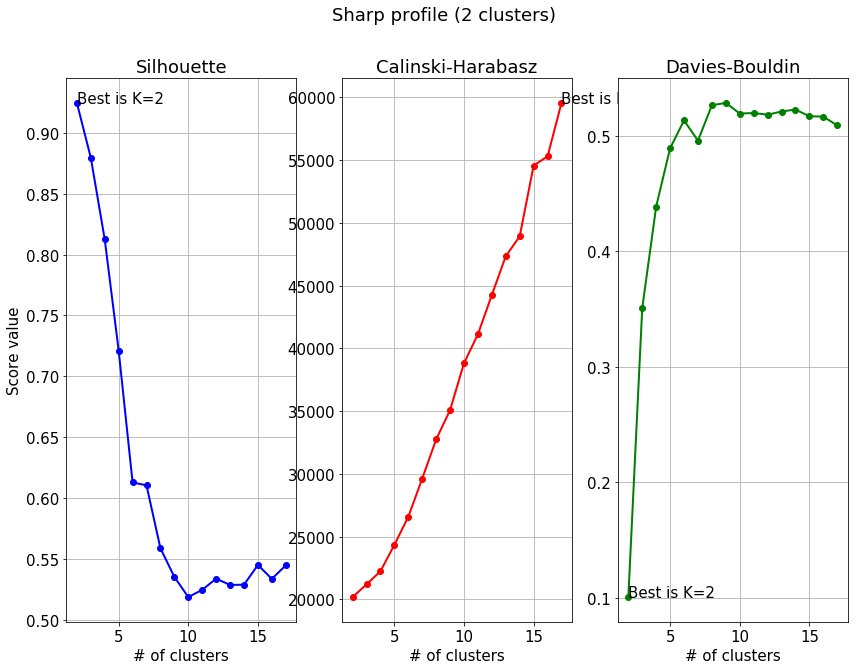

In [159]:
fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(14,10))
axs[0].plot(K_values,silh,'b-o',linewidth=2)
kopt=np.argmax(silh)+2
print("Silhouette max=",silh[kopt-2])
axs[0].text(x=kopt,y=silh[kopt-2],s="Best is K={}".format(kopt))
axs[0].set_title("Silhouette")
axs[0].set_xlabel("# of clusters")
axs[0].set_ylabel("Score value")
axs[0].grid(True)


axs[1].plot(K_values,ch,'r-o',linewidth=2,label="Best is K={}".format(np.argmax(ch)+2))
kopt=np.argmax(ch)+2
print("Calinski-Harabasz max=",ch[kopt-2])
axs[1].text(x=kopt,y=ch[kopt-2],s="Best is K={}".format(kopt))
axs[1].set_title("Calinski-Harabasz")
axs[1].set_xlabel("# of clusters")
axs[1].grid(True)


axs[2].plot(K_values,db,'g-o',linewidth=2,label="Best is K={}".format(np.argmin(db)+2))
kopt=np.argmin(db)+2
print("Davies-Bouldin min=",db[kopt-2])
axs[2].text(x=kopt,y=db[kopt-2],s="Best is K={}".format(kopt))
axs[2].set_title("Davies-Bouldin")
axs[2].set_xlabel("# of clusters")
axs[2].grid(True)

plt.suptitle("Sharp profile (2 clusters)")
plt.show(block=False)

In [160]:
K_values = np.arange(2,18)
silh=[]
ch=[]
db=[]
for k in K_values:
    km=KMeans(n_clusters=k)
    km.fit(c_bp)
    silh.append(silhouette_score(c_bp,km.labels_))
    ch.append(calinski_harabaz_score(c_bp,km.labels_))
    with np.errstate(divide='ignore'):
        db.append(davies_bouldin_score(c_bp,km.labels_))

Silhouette max= 0.6683597076074064
Calinski-Harabasz max= 8817.390290073976
Davies-Bouldin min= 0.4420005790864288


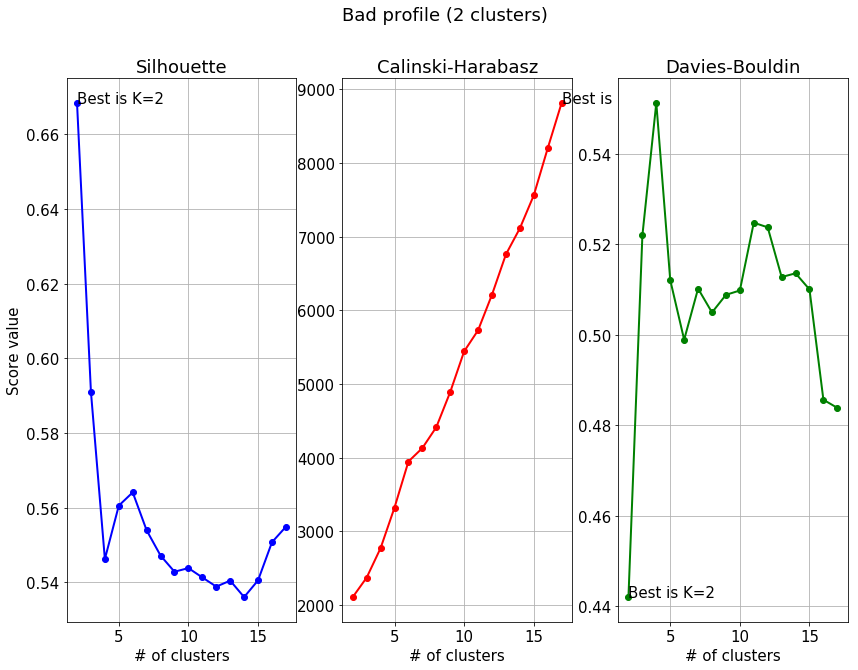

In [161]:
fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(14,10))
axs[0].plot(K_values,silh,'b-o',linewidth=2)
kopt=np.argmax(silh)+2
print("Silhouette max=",silh[kopt-2])
axs[0].text(x=kopt,y=silh[kopt-2],s="Best is K={}".format(kopt))
axs[0].set_title("Silhouette")
axs[0].set_xlabel("# of clusters")
axs[0].set_ylabel("Score value")
axs[0].grid(True)


axs[1].plot(K_values,ch,'r-o',linewidth=2,label="Best is K={}".format(np.argmax(ch)+2))
kopt=np.argmax(ch)+2
print("Calinski-Harabasz max=",ch[kopt-2])
axs[1].text(x=kopt,y=ch[kopt-2],s="Best is K={}".format(kopt))
axs[1].set_title("Calinski-Harabasz")
axs[1].set_xlabel("# of clusters")
axs[1].grid(True)


axs[2].plot(K_values,db,'g-o',linewidth=2,label="Best is K={}".format(np.argmin(db)+2))
kopt=np.argmin(db)+2
print("Davies-Bouldin min=",db[kopt-2])
axs[2].text(x=kopt,y=db[kopt-2],s="Best is K={}".format(kopt))
axs[2].set_title("Davies-Bouldin")
axs[2].set_xlabel("# of clusters")
axs[2].grid(True)

plt.suptitle("Bad profile (2 clusters)")
plt.show(block=False)

Les résultats sont les mêmes pour le profil "facile" et le profil "dur" :
  * Calinski-Harabasz croit indéfiniment : il n'est pas adapté pour cette forme de cluster.
  * Silhouette et Davies-Bouldin donnent un maximum à 2 puis stagnent autour de 0.54 et 0.50 respectivement.
  
La différence notable entre les deux profils, pour tous les scores, est leurs valeurs.
La meilleure valeur de score atteint
  * 0.92 pour la silhouette dans le bon profil, contre 0.66 pour le mauvais profil
  * 59000 pour Calinki-Harabasz dans le bon profil, contre 8000 pour le mauvais profil
  * 0.1 pour Davies-Bouldin dans le bon profil, contre 0.44 pour le mauvais profil

**Conclusion**: pour distinguer un profil séparable d'un profil non séparable par les Kmeans, on peut utiliser les score de silhouette et de Davies-Bouldin.
Pour qu'un profil soit séparable, il faut que la valeur optimale du score soit suffisante: cette expérience conseille >0.7 pour la silhouette, <0.2 pour Davies-Bouldin.